In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
%pip install -qq -U datasets transformers pyarrow torchinfo
%pip install -qq --upgrade transformers ftfy accelerate regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install GPUtil
%pip install --q -U pytorch-lightning lightning-bolts


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.2 which is incompatible.
beatrix-jupyterlab 2023.814.150030 requires jupyter-server~=1.16, but you have jupyter-server 2.12.3 which is incompatible.
beatrix-jupyterlab 2023.814.150030 requires jupyterlab~=3.4, but you have jupyterlab 4.0.10 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompat

**All the imports**

In [3]:
import os
import gc
import torch
import pickle
import json
import torchinfo
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from tqdm import tqdm
from pathlib import Path
#from GPUtil import showUtilization as gpu_usage
from numba import cuda
from typing import Union, List
import torch.multiprocessing as mp 
from torch.cuda.amp import autocast
from matplotlib import pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import Callback
import torchmetrics
#mp.set_start_method('spawn')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%load_ext tensorboard
%tensorboard --logdir "/kaggle/working/" --port=6007

**Define Hyperparameters**

In [5]:
raw_images_path = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
train_dataset_path = '/kaggle/input/coco2017-clip-image-embeddings/coco_embeddings_clip_vision_1x768'
captions_path = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
captions_key = 'annotations'
batch_size = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
val_split_size = 0.1
projection_layer_in_channels = 24
projection_layer_out_channels = 2560
projection_hidden_size = 64
max_training_steps = 100000
seq_len = 32
log_dir = '/kaggle/working/'
exp_name = 'phi2_proj_layer'
check_point_save_dir = '/kaggle/working/phi2_projection_checkpoints/'
os.makedirs(check_point_save_dir,exist_ok = True)
save_freq = 1000
val_check_interval = 1000

First, the projection layer...

In [6]:
class IdentityMap(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, *args, **kwargs):
        return x

    @property
    def config(self):
        return {"mm_projector_type": 'identity'}


class SimpleResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pre_norm = nn.LayerNorm(in_channels)

        self.proj = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels)
        )
    def forward(self, x):
        x = self.pre_norm(x)
        return x + self.proj(x)


class SimpleLinearBlock(nn.Module):
    def __init__(self, in_size, out_size, hidden_size = 50, add_residual_connection=True):
        super().__init__()
        self.pre_norm = nn.LayerNorm(in_size)
        self.proj = nn.Sequential(nn.Linear(in_size, hidden_size),
                                  nn.GELU(),
                                  nn.Linear(hidden_size, out_size))
        self.add_residual_connection = add_residual_connection
        
    def forward(self,x):
        return self.proj(x)


In [7]:
def model_summary(model, input_size):
    torchinfo.summary(model, 
                      input_size = input_size, 
                      batch_dim=0, 
                      col_names=("kernel_size",
                                 "input_size",
                                 "output_size",
                                 "num_params",
                                 "mult_adds"),
                       verbose=1,) 

In [8]:
projection_layer_in_channels = 24
projection_layer_out_channels = 2560
test_model = SimpleLinearBlock(projection_layer_in_channels,projection_layer_out_channels, hidden_size=64)
model_summary(test_model, (1,32,24))

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
SimpleLinearBlock                        --                        [1, 1, 32, 24]            [1, 1, 32, 2560]          48                        --
├─Sequential: 1-1                        --                        [1, 1, 32, 24]            [1, 1, 32, 2560]          --                        --
│    └─Linear: 2-1                       --                        [1, 1, 32, 24]            [1, 1, 32, 64]            1,600                     1,600
│    └─GELU: 2-2                         --                        [1, 1, 32, 64]            [1, 1, 32, 64]            --                        --
│    └─Linear: 2-3                       --                        [1, 1, 32, 64]            [1, 1, 32, 2560]          166,400                   166,400
Total params: 168,048
Trainable params: 168,048
Non-trainable params: 0
Total mult-adds (M): 0.17

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


**Pytorch Model definition**


In [10]:
class MultiModalGPT(nn.Module):
    """
    Pytorch Lightning module for Transformer

    """
    def __init__(self,
                 llm_model,
                 tokenizer,
                 projection_layer_in_channels,
                 projection_layer_out_channels,
                 hidden_size = 32,
                 ):
        super(MultiModalGPT, self).__init__()
        self.tokenizer = tokenizer
        self.projection_layer = SimpleLinearBlock(projection_layer_in_channels,projection_layer_out_channels, hidden_size=hidden_size)
        self.llm_model = llm_model
        
        # freeze the llm
        for param in self.llm_model.parameters():
            param.requires_grad = False
    
    
    def forward(self, x, max_length=1):
        #print(f"beginning of projection: {x.shape}")
        x = self.projection_layer(x)
        #print(f"end of projection: {x.shape}")
        with torch.no_grad():  
            x = self.llm_model(inputs_embeds = x, return_dict=False)
        #print(f"end of llm: logits: {x[0].shape}")
        return x
    
    def generate(self, x):
        proj_outs = self.projection_layer(x)
        with torch.no_grad():
            output_tokens = self.llm_model.generate(**proj_outs, max_length=200)
            generated_text = self.tokenizer.batch_decode(output_tokens)[0]
        return generated_text

**Loss Function**

In [11]:
def chunked_cross_entropy(
    logits: Union[torch.Tensor, List[torch.Tensor]], targets: torch.Tensor, chunk_size: int = 128
) -> torch.Tensor:
    # with large max_sequence_lengths, the beginning of `backward` allocates a large memory chunk which can dominate
    # the memory usage in fine-tuning settings with low number of parameters.
    # as a workaround hack, the cross entropy computation is chunked to force it to deallocate on the go, reducing
    # the memory spike's magnitude

    # lm_head was chunked (we are fine-tuning)
    if isinstance(logits, list):
        # don't want to chunk cross entropy
        if chunk_size == 0:
            logits = torch.cat(logits, dim=1)
            logits = logits.reshape(-1, logits.size(-1))
            targets = targets.reshape(-1)
            return torch.nn.functional.cross_entropy(logits, targets, ignore_index=-1)

        # chunk cross entropy
        logit_chunks = [logit_chunk.reshape(-1, logit_chunk.size(-1)) for logit_chunk in logits]
        target_chunks = [target_chunk.reshape(-1) for target_chunk in targets.split(logits[0].size(1), dim=1)]
        loss_chunks = [
            torch.nn.functional.cross_entropy(logit_chunk, target_chunk, ignore_index=-1, reduction="none")
            for logit_chunk, target_chunk in zip(logit_chunks, target_chunks)
        ]
        return torch.cat(loss_chunks).mean()

    # no chunking at all
    logits = logits.reshape(-1, logits.size(-1))
    targets = targets.reshape(-1)
    if chunk_size == 0:
        return torch.nn.functional.cross_entropy(logits, targets, ignore_index=-1)

    # lm_head wasn't chunked, chunk cross entropy
    logit_chunks = logits.split(chunk_size)
    target_chunks = targets.split(chunk_size)
    loss_chunks = [
        torch.nn.functional.cross_entropy(logit_chunk, target_chunk, ignore_index=-1, reduction="none")
        for logit_chunk, target_chunk in zip(logit_chunks, target_chunks)
    ]
    return torch.cat(loss_chunks).mean()

**Pytorch Lightning Model definition**

In [13]:
class LitMultiModalGPT(LightningModule):
    """
    Pytorch Lightning module for Transformer

    """
    def __init__(self,
                 projection_layer_in_channels,
                 projection_layer_out_channels,
                 hidden_size = 32,
                 num_validation_examples=2,
                 num_training_steps=100000):
        super().__init__()
        self.num_validation_examples = num_validation_examples
        self.num_training_steps = num_training_steps
        self.scheduler = None
        self.scheduler_dict = {}
        self.optimizer = None
        self.this_step_train_loss = None
        self.predicted_list = []
        self.expected_list = []
        self.save_hyperparameters(ignore=['loss_criterion', 'epoch'])
        self.projection_layer = SimpleLinearBlock(projection_layer_in_channels,projection_layer_out_channels, hidden_size=hidden_size)
        self.llm_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype=torch.bfloat16)
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
        self.train_loss_values = []
        self.val_loss_values = []

     
        # freeze the llm
        for param in self.llm_model.parameters():
            param.requires_grad = False
    
    

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    
    def set_scheduler_dict(self, scheduler, freq='step'):
        self.scheduler = scheduler
        self.scheduler_dict = {
            "scheduler": self.scheduler,
            "interval": freq,
        }

    def configure_optimizers(self):
        if self.scheduler_dict:
            return {"optimizer": self.optimizer, "lr_scheduler": self.scheduler_dict}
        return {"optimizer": self.optimizer}
         
   
    def forward(self, x):
        #print(f"beginning of projection: {x.shape}")
        x = self.projection_layer(x)
        #print(f"end of projection: {x.shape}")
        x = self.llm_model(inputs_embeds = x, return_dict=False)
        #print(f"end of llm: logits: {x[0].shape}")
        return x

    def generate(self, x):
        proj_outs = self.projection_layer(x)
        with torch.no_grad():
            pred_logits, outputs = self.llm_model(inputs_embeds = proj_outs, return_dict=False)
            output_tokens = torch.argmax(pred_logits, axis=-1)  
            generated_text = self.tokenizer.batch_decode(output_tokens)[0]
        return generated_text
    
    
    def evaluate(self,batch, stage):
        if stage:
            predicted = self.generate(batch['image_embeddings'])
            #self.predicted_list.append(predicted)
            #self.expected_list.append(batch['caption'])
            # print the source, target, and the model output
            print("*****************************************")
            print(f"{f'Input: ' :>12}{batch['caption']}")
            print(f"{f'predicted: ' :>12}{predicted}")
            print("*****************************************\n")
        return predicted

    def training_step(self, batch):
        targets = batch['tokenized_caption']  # (B, seq_len)
        #self.llm_model.to(device)
        with torch.autocast(device_type="cuda"):
            logits, outputs = self(batch['image_embeddings'])
            #print(f"logits: {logits.shape}, targets: {targets.shape}")
            loss = chunked_cross_entropy(logits, targets, chunk_size=0)
        torch.cuda.empty_cache()
        gc.collect()
        #self.llm_model.to("cpu")
        self.log("train_loss", loss.item(), prog_bar=True)
        self.this_step_train_loss = loss.item()
        self.train_loss_values.append(self.this_step_train_loss)
        return loss

    
    def validation_step(self, batch, batch_idx):
        if batch_idx < self.num_validation_examples:
            predicted = self.evaluate(batch, "val")
            if batch_idx % 10000 == 0:
                raw_img_path = batch['raw_image_path'][0]
                print(raw_img_path)
                image = Image.open(raw_img_path)
                plt.imshow(image)
                plt.show()
                print("*****************************************")
                print(f"{f'Input: ' :>12}{batch['caption']}")
                print(f"{f'predicted: ' :>12}{predicted}")
                print("*****************************************\n")



    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")



**Define Trainer**

In [14]:
class PeriodicCheckpoint(ModelCheckpoint):
    def __init__(self, checkpoint_save_dir, save_freq, verbose: bool = False):
        super().__init__()
        self.verbose = verbose
        self.save_dir = checkpoint_save_dir
        self.save_freq = save_freq

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if batch_idx % self.save_freq == 0:
            # save the model at the end of every epoch
            model_filename = os.path.join(self.save_dir, f"ckpt_{trainer.global_step}.pt")
            # Save only the state_dict of projection layer
            torch.save(trainer.model.projection_layer.state_dict(), model_filename)

class PrintAccuracyAndLoss(Callback):
    def __init__(self):
        super().__init__()

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        train_loss = trainer.callback_metrics['train_loss']
        trainer.model.log("train_step_loss", train_loss)
        if batch_idx % 100 == 0:
            print(f"Step: {trainer.global_step}: train_loss={train_loss:.4f}")


In [15]:
 def train_multimodal_gpt_model(model, train_dataloader, val_dataloader, ckpt_path=None, max_training_steps=2):
    trainer = Trainer(
        enable_checkpointing=True,
        max_steps=max_training_steps,
        accelerator="auto", #"auto" if torch.cuda.is_available() else "cpu",
        devices = 1, 
        logger=TensorBoardLogger(save_dir=log_dir, name=exp_name, default_hp_metric=False),
        callbacks=[LearningRateMonitor(logging_interval="step"),
                   TQDMProgressBar(refresh_rate=10),
                   PeriodicCheckpoint(check_point_save_dir, save_freq, verbose=True),
                   PrintAccuracyAndLoss()],
        num_sanity_val_steps=0,
        val_check_interval = val_check_interval,
        precision="16"
    )
    
    trainer.fit(model, train_dataloader, val_dataloader, ckpt_path=ckpt_path)
    return trainer

**Data loader**

In [16]:
def get_absolute_paths(directory_path, max_files = None):
    absolute_paths = []
    image_ids = []

    # Check if the given path is a valid directory
    if os.path.isdir(directory_path):
        # Iterate over all files in the directory
        for root, _, files in os.walk(directory_path):
            for file in tqdm(files):
                # extract image ID
                image_ids.append(Path(file).stem)
                # Construct the absolute path for each file
                absolute_path = os.path.abspath(os.path.join(root, file))
                absolute_paths.append(absolute_path)
                if max_files is not None and len(absolute_paths) > max_files:
                    break
    return absolute_paths, image_ids


def parse_captions_file(captions_path, captions_key):
    """
    Read a JSON file and return its contents as a dictionary.

    Parameters:
    - file_path (str): The path to the JSON file.

    Returns:
    - dict: The contents of the JSON file as a dictionary.
    """
    try:
        with open(captions_path, 'r') as file:
            data = json.load(file)
        captions = {}
        annotations = data[captions_key]
        for annotation in annotations:
            captions[annotation['image_id']] = annotation['caption']
        return captions
    except FileNotFoundError:
        print(f"Error: File not found - {captions_path}")
    except json.JSONDecodeError:
        print(f"Error: Unable to decode JSON in file - {captions_path}")

        
def load_pickle_file(file_path):
    with open(file_path, 'rb') as fh:
        data = pickle.load(fh)
    keys = list(data.keys()) 
    assert len(keys) == 1
    return data[keys[0]]


class PickleDataset(Dataset):

    def __init__(self, 
                 raw_images_path,
                 embeddings_path,
                 image_ids,
                 captions_path,
                 captions_key,
                 tokenizer, 
                 seq_len=768):
        super().__init__()
        self.tokenizer = tokenizer
        self.ds = None
        self.raw_images_path = raw_images_path
        self.captions_key = captions_key
        self.embeddings_path = embeddings_path
        self.image_ids = image_ids
        self.bos_token = self.tokenizer.bos_token
        self.eos_token = self.tokenizer.eos_token
        self.seq_len = seq_len
        self.captions = parse_captions_file(captions_path, captions_key)
        

    def __len__(self):
        return len(self.image_ids)


    def __getitem__(self, idx):

        # get image embeddings
        img_embds = load_pickle_file(self.embeddings_path[idx])
        img_embds = torch.tensor(np.squeeze(img_embds))
        img_embds = img_embds.view(32,24)
        #print(img_embds.shape)
        this_img_id = self.image_ids[idx]
        #print(this_img_id)
        this_img_f_name = "{:012d}".format(int(this_img_id))+'.jpg'
        
        # get caption
        caption = self.captions[int(this_img_id)]
        tokenized_caption = self.tokenize_caption(caption)
        
        return {
            "image_embeddings": img_embds,
            "raw_image_path": os.path.join(self.raw_images_path, this_img_f_name),
            "caption": caption,
            "tokenized_caption": tokenized_caption
        }
    
    def tokenize_caption(self, caption):
        tokens = self.tokenizer(caption)
        tokenizer_output = self.tokenizer(caption, return_tensors="pt", return_attention_mask=False)
        caption_encoded = tokenizer_output['input_ids'].squeeze()
        if len(caption_encoded) > self.seq_len:
            caption_encoded = caption_encoded[:self.seq_len-2]
        num_padding_tokens = self.seq_len - len(caption_encoded) - 1
        # Add <s> and </s> token
        tokenized_caption = torch.cat(
            [
                torch.tensor([self.tokenizer.bos_token_id],dtype=torch.int64),
                caption_encoded.squeeze(),
                torch.tensor([self.tokenizer.eos_token_id]*num_padding_tokens,dtype=torch.int64),
            ],dim=0)
        #print(f"caption length: {len(caption_encoded)} number of padding tokens: {num_padding_tokens} total size: {len(tokenized_caption)}")
        return tokenized_caption


**Define train dataset and train dataloader**

In [17]:
files_list, images_ids_list = get_absolute_paths(train_dataset_path)
files_list = np.array(files_list)
images_ids_list = np.array(images_ids_list)
rand_indices = np.arange(len(files_list))
np.random.shuffle(rand_indices)

val_split = int(len(files_list)*val_split_size)

val_filepaths, train_filepaths = files_list[rand_indices[:100]], files_list[rand_indices[100:]] 
val_image_ids, train_image_ids = images_ids_list[rand_indices[:100]], images_ids_list[rand_indices[100:]]

print(f"Train dataset size: {len(train_filepaths)}")
print(f"Valid dataset size: {len(val_filepaths)}")

100%|██████████| 118285/118285 [00:01<00:00, 69433.03it/s]


Train dataset size: 118185
Valid dataset size: 100


In [18]:
phi_tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
train_ds = PickleDataset(raw_images_path, train_filepaths, train_image_ids, captions_path, captions_key, phi_tokenizer, seq_len = seq_len)
val_ds = PickleDataset(raw_images_path, val_filepaths, val_image_ids, captions_path, captions_key, phi_tokenizer, seq_len = seq_len)



tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
train_dataloader = DataLoader(dataset = train_ds,
                              batch_size = batch_size,
                              num_workers = 1,
                              collate_fn = None,
                              shuffle = True)
val_dataloader = DataLoader(dataset = val_ds,
                            batch_size = 1,
                            num_workers = 1,
                            collate_fn = None,
                            shuffle = True)

In [20]:
#del multimodal_gpt_model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
cc = next(iter(train_dataloader))
input_embeds = cc['image_embeddings']
print(input_embeds.shape)
#pred_logits = multimodal_gpt_model.llm_model(inputs_embeds=input_embeds, return_dict=False)
batch_size, seq_length, _ = input_embeds.shape
## Get the predicted token IDs
#output_tokens = torch.argmax(pred_logits, axis=-1)  
#text = phi_tokenizer.batch_decode(output_tokens)[0]
        
## Convert token IDs to words using the vocabulary and the StringLookup

##inputs = phi_tokenizer("hello", return_tensors="pt", return_attention_mask=False)
##output_tokens = phi_model.generate(**inputs, max_length=20)
##text = phi_tokenizer.batch_decode(output_tokens)[0]
#print(text)

**Define model and optimizer**

In [32]:
gc.collect()

1745

In [21]:
multimodal_gpt_model = LitMultiModalGPT(projection_layer_in_channels,
                                        projection_layer_out_channels,
                                        hidden_size = projection_hidden_size)
optimizer = torch.optim.Adam(multimodal_gpt_model.parameters(), lr=2.0e-3, eps=1e-9)
multimodal_gpt_model.set_optimizer(optimizer)

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/phi-2 were not used when initializing PhiForCausalLM: ['model.layers.26.self_attn.q_proj.bias', 'model.layers.27.self_attn.q_proj.bias', 'model.layers.23.self_attn.k_proj.weight', 'model.layers.27.self_attn.q_proj.weight', 'model.layers.28.self_attn.k_proj.weight', 'model.layers.29.self_attn.k_proj.bias', 'model.layers.2.self_attn.v_proj.weight', 'model.layers.26.self_attn.k_proj.bias', 'model.layers.8.self_attn.k_proj.bias', 'model.layers.11.self_attn.k_proj.weight', 'model.layers.8.self_attn.v_proj.bias', 'model.layers.19.self_attn.q_proj.bias', 'model.layers.18.self_attn.q_proj.weight', 'model.layers.22.self_attn.q_proj.weight', 'model.layers.9.self_attn.q_proj.weight', 'model.layers.17.self_attn.v_proj.weight', 'model.layers.28.self_attn.q_proj.weight', 'model.layers.25.self_attn.k_proj.bias', 'model.layers.18.self_attn.v_proj.weight', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.24.self_attn.q_proj.weight', 'model.layers.

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


**Train the model**

In [23]:
gc.collect()
torch.cuda.empty_cache()

In [22]:
count_parameters(multimodal_gpt_model)

168048

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the

Training: 0it [00:00, ?it/s]

Step: 1: train_loss=10.9549
Step: 101: train_loss=3.3492
Step: 201: train_loss=2.2153
Step: 301: train_loss=3.9032
Step: 401: train_loss=3.4793
Step: 501: train_loss=2.4116
Step: 601: train_loss=2.4369
Step: 701: train_loss=2.8012
Step: 801: train_loss=2.8326
Step: 901: train_loss=2.1745


Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['A river with several ducks floating in it with frozen banks.']
 predicted: <|endoftext|>A woman a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000258738.jpg


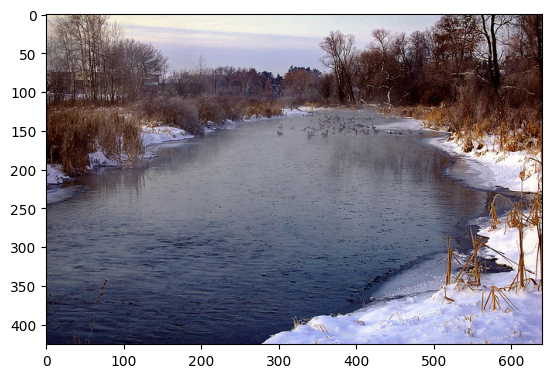

*****************************************
     Input: ['A river with several ducks floating in it with frozen banks.']
 predicted: <|endoftext|>A woman a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['A woman is sitting on a suitcase by a trailer.']
 predicted: <|endoftext|>A woman a a a a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

Step: 1001: t

Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['A young girl using a laptop at the beach. ']
 predicted: <|endoftext|>A man a a a a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000448958.jpg


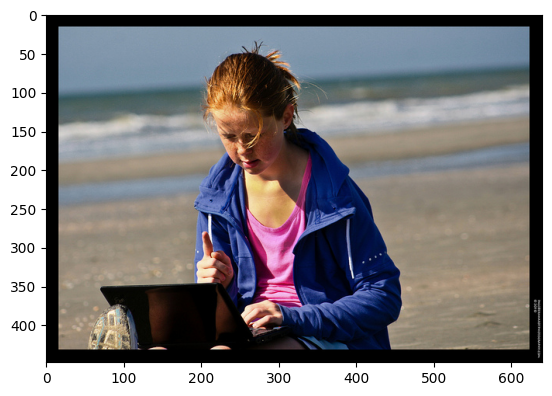

*****************************************
     Input: ['A young girl using a laptop at the beach. ']
 predicted: <|endoftext|>A man a a a a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['a baseball player walking into a batters box at a baseball game']
 predicted: <|endoftext|>A man is a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

Step: 2001: train_loss=2.7986
Step: 210

Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['A baby elephant is walking behind her mother. ']
 predicted: <|endoftext|>A elephant of a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000521288.jpg


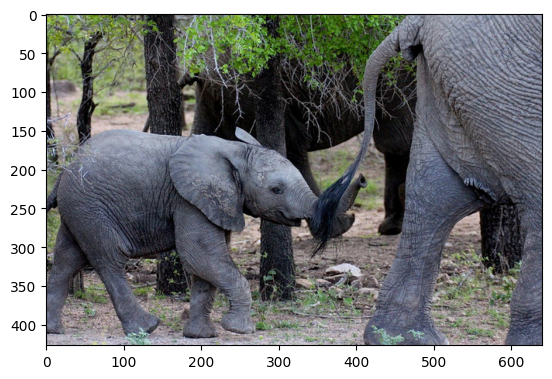

*****************************************
     Input: ['A baby elephant is walking behind her mother. ']
 predicted: <|endoftext|>A elephant of a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['A black and white photo of a cavalry of men on horses.']
 predicted: <|endoftext|>A woman a a a a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

Step: 3001: train_loss=2.1753
Step: 3101: train_

Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['a woman wearing a giant banana on her head in front of some buildings']
 predicted: <|endoftext|>A man is a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000065965.jpg


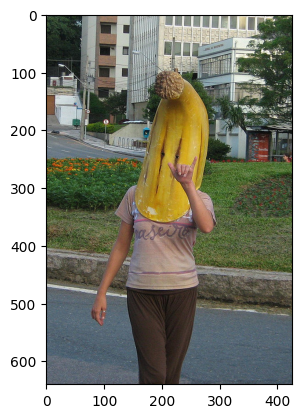

*****************************************
     Input: ['a woman wearing a giant banana on her head in front of some buildings']
 predicted: <|endoftext|>A man is a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['a cross walk sign at Old Morgan School Place']
 predicted: .A in of in.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['pair of zebras grazing in a desert setting.']
 predicted: <|endoftext|>A gir ze ze a a a a a.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000188718.jpg


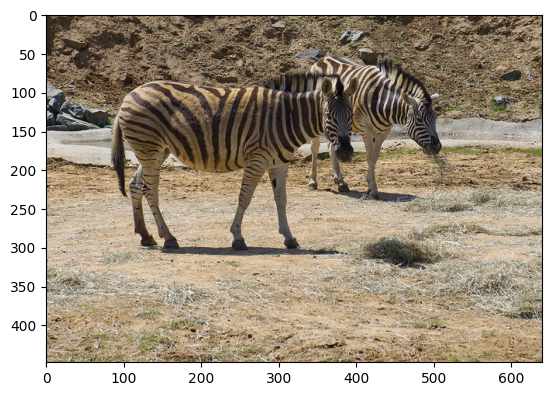

*****************************************
     Input: ['pair of zebras grazing in a desert setting.']
 predicted: <|endoftext|>A gir ze ze a a a a a.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['a living room with some couches and a table top']
 predicted: <|endoftext|>A kitchen room room a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

Step: 5001: train_loss=3.1170
Ste

Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['Stairs that have some fading green paint on them.']
 predicted: <|endoftext|>A man man a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000308003.jpg


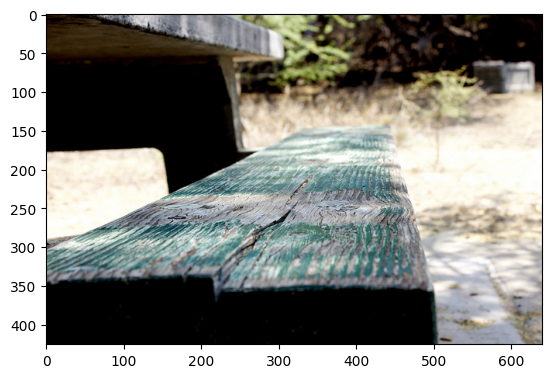

*****************************************
     Input: ['Stairs that have some fading green paint on them.']
 predicted: <|endoftext|>A man man a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['A young woman holding up a  smart phone device.']
 predicted: <|endoftext|>A of of a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
***********************************

Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['A man behind a woman brushing her teeth in a bathroom mirror. ']
 predicted: <|endoftext|>A woman a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000121237.jpg


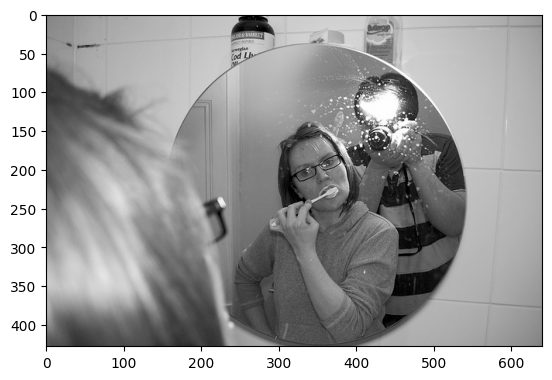

*****************************************
     Input: ['A man behind a woman brushing her teeth in a bathroom mirror. ']
 predicted: <|endoftext|>A woman a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['The photo of  the train station is overexposed.']
 predicted: <|endoftext|> a a<|endoftext|><|endoftext|><|endoftext|> a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft

Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['one woman and two men are eating pizza ']
 predicted: <|endoftext|>A man of a a a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000031729.jpg


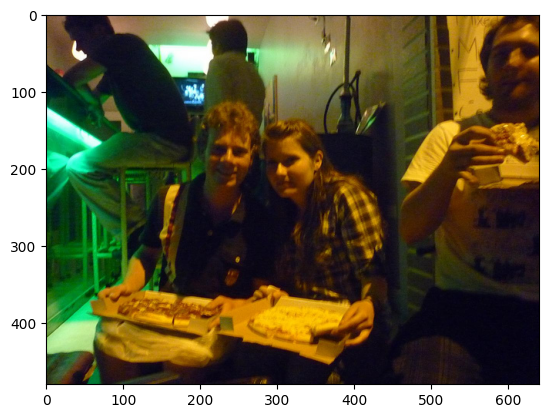

*****************************************
     Input: ['one woman and two men are eating pizza ']
 predicted: <|endoftext|>A man of a a a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['A child wearing a helmet is holding a tennis racket.']
 predicted: <|endoftext|>A man boy a a a a a a<|endoftext|> a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

Step: 8001: train_loss=1.7705
Step: 8101: train_loss=2.2629
Step: 8201: t

Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['The duck is in the water with little ducklings.']
 predicted: <|endoftext|>A of of of<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000452834.jpg


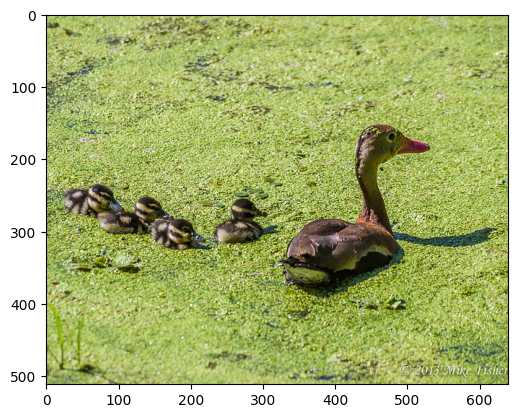

*****************************************
     Input: ['The duck is in the water with little ducklings.']
 predicted: <|endoftext|>A of of of<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['A crowd of people parked near a double decker bus.']
 predicted: <|endoftext|>A people of a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
********************

Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['A cat that is walking on a mirrored surface.']
 predicted: <|endoftext|>A dog in a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000352787.jpg


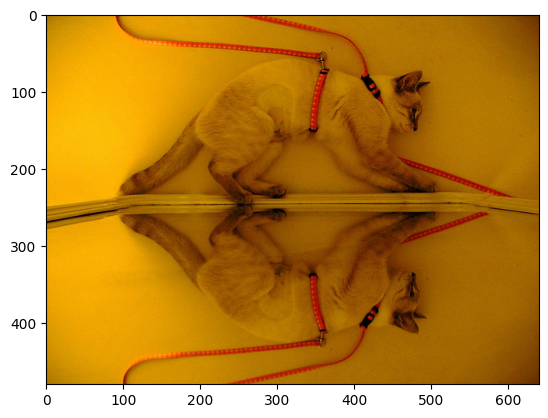

*****************************************
     Input: ['A cat that is walking on a mirrored surface.']
 predicted: <|endoftext|>A dog in a a a a a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['A computer monitor, keyboard, mouse and printer at a desk.']
 predicted: <|endoftext|>A computer and a a a a a and a a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

Step: 10001: train_loss=2.4302
Step: 10101: 

Validation: 0it [00:00, ?it/s]

*****************************************
     Input: ['Several kites soar near the water at a beach.']
 predicted: <|endoftext|>A surf on a<|endoftext|> a beach the the<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000551685.jpg


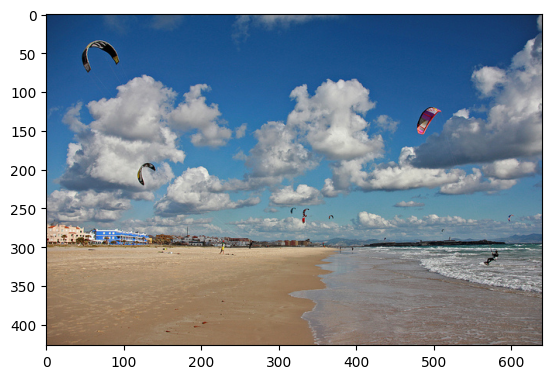

*****************************************
     Input: ['Several kites soar near the water at a beach.']
 predicted: <|endoftext|>A surf on a<|endoftext|> a beach the the<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
*****************************************

*****************************************
     Input: ['A birthday cake with a Thomas the Train on it.']
 predicted: <|endoftext|>A plate a of of<|endoftext|> a<|endoftext|><|endoftext|> a<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
***************************************

ValueError: Expected input batch_size (32) to match target batch_size (33).

In [24]:
trainer = train_multimodal_gpt_model(multimodal_gpt_model, train_dataloader, val_dataloader, max_training_steps=max_training_steps)

In [ ]:
#del phi_model
print(torch.cuda.memory_allocated())
test_llm_model.to("cpu")
gc.collect()
#del input_embeds
#del phi_model
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
#print(torch.cuda.memory_reserved())

In [ ]:
input_embeds

In [ ]:
#input_embeds = cc['image_embeddings'].to(device)
#output = multimodal_gpt_model.generate(input_embeds)

In [ ]:
test_llm_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2")
test_llm_model = test_llm_model.to(device)

In [ ]:
!nvidia-smi